###Implementación de MLP para predicción de trayectoria de peatones

In [ ]:
#!unzip '/content/drive/MyDrive/ProyectoSL2/data/stanford-dataset-meters.zip' -d '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters'


Instalación de wandb para observar el comportamiento de los parametros del modelo

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="ProyectoSL2")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: silvya. Use `wandb login --relogin` to force relogin


####Preparación de Datos a utilizar

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
#Funcion para dividir una sequencia multivariable en muestras
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# Encontrar el final del patron
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		
		if out_end_ix > len(sequences): # verificar que si se llego al final del dataset
			break
		
		# unir entradas y salidas del patron
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
from random import Random	

#funcion para preparar la estructura de los datos para poder utilizarlo con estructura de aprendizaje supervisado
def sequences_to_supervised(dataframe, n_steps_in, n_steps_out, n_features):
  X_all = np.empty([0,n_steps_in,n_features]) # n_features = number of features: x, y
  y_all = np.empty([0,n_steps_out,n_features]) # n_features = number of features: x,y
       
  dataframe_groups = dataframe.groupby(['id']) #se agrupan las secuencias de cada peaton
  
  groups = list(dataframe.groupby(['id'])) 
  Random(1).shuffle(groups)  #secuencias aleatorias agrupadas por el id del peaton
 

  for group in groups:
    X, y = split_sequences(group[1].drop(columns=["id"]).values, n_steps_in,n_steps_out) # 2 features, x, y
         
    X_all = np.concatenate((X_all,X))
    y_all = np.concatenate((y_all,y))
                   
  return X_all, y_all    

In [ ]:
n_features = 2   # features x, y (posicion del peaton en un tiempo t)
n_steps_in = 8   # 8 pasos de entrada (secuencia de trayectoria inicial)
n_steps_out = 12 # 12 pasos de salida (secuencia de trayectoria a predecir)

Extracción y carga de datos a utilizar para el entrenamiento del modelo

In [ ]:
#los datos se encuentran en archivos por separado, se unen archivos para el training data
train_files = ['/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_0.txt',
               '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_1.txt',
               '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_2.txt']

df =pd.DataFrame()

for i in range(len(train_files)):
  data = pd.read_csv(train_files[i],sep=' ', header=None, names=['time','id','x','y'])
  data['id'] = data['id'].apply(lambda x: str(i)+str(x))

  df = pd.concat([df,data],ignore_index=True)

El dataset contiene cuatro columnas 

**id:** el id del peaton

**time:** contiene el tiempo de la secuencia de trayectoria de un peaton, son 20 timestep por cada peaton.

**x:** coordenada x en metros de la posición en un punto de la secuencia de trayectoria 

**y:** coordenada y en metros de la posicion en un punto de la secuencia de trayectoria 


In [ ]:
df.head(40)

,time,id,x,y
0,0,0100,1.728,14.378
1,12,0100,2.035,14.378
2,24,0100,2.342,14.378
3,36,0100,2.630,14.378
4,48,0100,2.937,14.416
5,60,0100,3.244,14.416
6,72,0100,3.551,14.416
7,84,0100,3.782,14.416
8,96,0100,4.089,14.416
9,108,0100,4.242,14.512


El dataset contiene en total 1772 trayectorias

Las posiciones son de una imagen en un plano con coordenadas (x,y), con el origen en medio de la imagen, por esto se tienen coordenas positivas y negativas. 

Coordenadas  -28.579 < x < 28.518, -21.754 < y < 21.714

Con lo que se obtiene un área de estudio de 2481.89 metros cuadrados

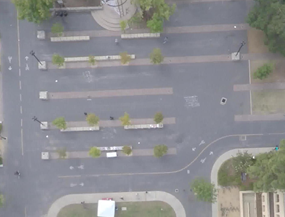

In [ ]:
df.describe(include='all')

,time,id,x,y
count,35440.000000,35440,35440.000000,35440.000000
unique,NaN,1772,NaN,NaN
top,NaN,0100,NaN,NaN
freq,NaN,20,NaN,NaN
mean,7143.284424,NaN,-1.710165,2.422755
std,4040.345357,NaN,14.818010,12.437575
min,0.000000,NaN,-28.579000,-21.754000
25%,3552.000000,NaN,-14.005250,-9.175000
50%,7332.000000,NaN,-3.321000,2.380000
75%,10536.000000,NaN,9.291000,15.683000


Normalización de los datos de entrenamiento:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

id_column = df.id
df.drop(columns=['time','id'], axis=1, inplace=True) #se quita la feature time del dataset

#Normalizando datos de posición
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns) #se normalizan unicamente las feature x,y

df['id'] = id_column

import pickle as pkl
with open('/content/drive/MyDrive/ProyectoSL2/data/models/MLP/scaler.pkl', 'wb') as outfile: #se guarda el scaler para poder desnormalizar despues los datos
  pkl.dump(scaler, outfile)

Training data normalizados:

In [ ]:
df.head(5)

,x,y,id
0,0.530798,0.831232,0100
1,0.536175,0.831232,0100
2,0.541552,0.831232,0100
3,0.546596,0.831232,0100
4,0.551973,0.832106,0100


In [ ]:
#división de features x, y para utilizarlos en el modelo de entrada multiple
X,y = sequences_to_supervised(df,n_steps_in,n_steps_out, n_features)


In [ ]:
print(X.shape) #1772 muestras, de 8 pasos de entrada, con 2 caracteristicas (posicion coordenadas x,y)
print(y.shape) #1772 muestras, de 12 pasos de salida, con 2 caracteristicas (posicion coordenadas x,y)

(1772, 8, 2)
(1772, 12, 2)


In [ ]:
print("X:",X.shape[0],"muestras, de",X.shape[1],"pasos de entrada, con",X.shape[2],"caracteristicas que corresponden a las coordenadas de la posición")
print("y:",y.shape[0],"muestras, de",y.shape[1],"pasos de salida, con",y.shape[2],"caracteristicas que corresponden a las coordenadas de la posición")

X: 1772 muestras, de 8 pasos de entrada, con 2 caracteristicas que corresponden a las coordenadas de la posición
y: 1772 muestras, de 12 pasos de salida, con 2 caracteristicas que corresponden a las coordenadas de la posición


Redimension de datos para poder procesarlos con MLP

In [ ]:
# flatten input
n_input = X.shape[1] * X.shape[2] #dimension input 
X_flatten = X.reshape((X.shape[0], n_input)) #1772,16

# flatten conditional y
n_input = y.shape[1] * y.shape[2] #dimension output
y_flatten = y.reshape((y.shape[0],n_input)) #1772,24


Ejemplo de una secuencia de datos redimensionados, X:8 pasos de entrada, y:12 de salida

In [ ]:
print("X:",X_flatten[0]) 
print("y:",y_flatten[0])

X: [0.56726273 0.29166283 0.56726273 0.29166283 0.56726273 0.29166283
 0.56726273 0.29166283 0.56726273 0.29166283 0.56831357 0.28846508
 0.57249943 0.2843241  0.57249943 0.28202356]
y: [0.57109831 0.28202356 0.56901413 0.28202356 0.56796329 0.28202356
 0.56656217 0.28202356 0.56516104 0.28202356 0.56446048 0.28340388
 0.56446048 0.28248367 0.56516104 0.28340388 0.5658616  0.2843241
 0.56516104 0.2843241  0.56446048 0.28340388 0.56237631 0.28294377]


####Creación modelo MLP

#####Creación de la estructura:

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu',input_dim=16)) #dimensiones de entrada, secuencia de 8 pasos con 2 coordenadas(x,y)
#model.add(tf.keras.layers.Dense(128, activation='relu',input_dim=16)) #dimensiones de entrada

model.add(tf.keras.layers.Dense(24)) #capa de salida 24, secuencia de 12 pasos con 2 coordenadas(x,y)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-08, decay=0.0), loss='mse') #problema de regresion


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1700      
                                                                 
 dense_1 (Dense)             (None, 24)                2424      
                                                                 
Total params: 4,124
Trainable params: 4,124
Non-trainable params: 0
_________________________________________________________________


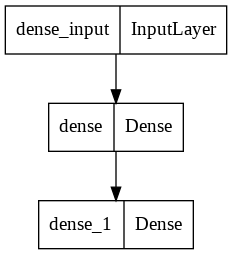

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
#callback para monitorear el costo
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


#####Entrenamiento del modelo:

In [ ]:
model.fit(X_flatten,y_flatten, epochs=200, validation_split=0.2, callbacks=[wandb_callback], batch_size=8)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/200
  1/178 [..............................] - ETA: 1:58 - loss: 0.3505

176/178 [============================>.] - ETA: 0s - loss: 0.0335

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 4s 16ms/step - loss: 0.0333 - val_loss: 0.0030
Epoch 2/200
177/178 [============================>.] - ETA: 0s - loss: 0.0030

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 2s 12ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/200
168/178 [===========================>..] - ETA: 0s - loss: 0.0028

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/200
169/178 [===========================>..] - ETA: 0s - loss: 0.0026

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 2s 13ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/200
175/178 [============================>.] - ETA: 0s - loss: 0.0023

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 2s 13ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/200
171/178 [===========================>..] - ETA: 0s - loss: 0.0021

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 2s 13ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 7/200
178/178 [==============================] - ETA: 0s - loss: 0.0020

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.2s


178/178 [==============================] - 2s 12ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/200
178/178 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/200
163/178 [==========================>...] - ETA: 0s - loss: 0.0015

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/200
165/178 [==========================>...] - ETA: 0s - loss: 0.0014

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 11/200
173/178 [============================>.] - ETA: 0s - loss: 0.0011

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 8.7462e-04
Epoch 12/200
177/178 [============================>.] - ETA: 0s - loss: 0.0010

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 7.8167e-04
Epoch 13/200
178/178 [==============================] - 0s 2ms/step - loss: 8.5147e-04 - val_loss: 8.7067e-04
Epoch 14/200
165/178 [==========================>...] - ETA: 0s - loss: 7.7527e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 7ms/step - loss: 7.6714e-04 - val_loss: 5.3195e-04
Epoch 15/200
172/178 [===========================>..] - ETA: 0s - loss: 6.3196e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 6.4115e-04 - val_loss: 4.5077e-04
Epoch 16/200
175/178 [============================>.] - ETA: 0s - loss: 5.8115e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 5.8816e-04 - val_loss: 4.1463e-04
Epoch 17/200
178/178 [==============================] - 0s 2ms/step - loss: 4.9090e-04 - val_loss: 4.4046e-04
Epoch 18/200
155/178 [=========================>....] - ETA: 0s - loss: 4.4811e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 4.5144e-04 - val_loss: 2.9307e-04
Epoch 19/200
178/178 [==============================] - 0s 2ms/step - loss: 4.6749e-04 - val_loss: 2.9976e-04
Epoch 20/200
178/178 [==============================] - 0s 2ms/step - loss: 3.9234e-04 - val_loss: 2.9330e-04
Epoch 21/200
178/178 [==============================] - 0s 2ms/step - loss: 3.5805e-04 - val_loss: 5.2007e-04
Epoch 22/200
163/178 [==========================>...] - ETA: 0s - loss: 3.8882e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 3.8414e-04 - val_loss: 2.4381e-04
Epoch 23/200
178/178 [==============================] - 0s 2ms/step - loss: 3.8534e-04 - val_loss: 4.4427e-04
Epoch 24/200
178/178 [==============================] - 0s 2ms/step - loss: 3.9122e-04 - val_loss: 4.6340e-04
Epoch 25/200
178/178 [==============================] - 0s 2ms/step - loss: 3.5985e-04 - val_loss: 3.0861e-04
Epoch 26/200
178/178 [==============================] - 0s 3ms/step - loss: 3.1166e-04 - val_loss: 3.6292e-04
Epoch 27/200
178/178 [==============================] - 0s 2ms/step - loss: 3.8298e-04 - val_loss: 3.4720e-04
Epoch 28/200
178/178 [==============================] - 0s 2ms/step - loss: 3.4278e-04 - val_loss: 3.3421e-04
Epoch 29/200
178/178 [==============================] - 0s 2ms/step - loss: 3.4552e-04 - val_loss: 2.5001e-04
Epoch 30/200
178/178 [==============================] - 0s 2ms/step - loss: 3.0395e-04 - val_loss: 2.6545e-04
Epoch 31/200
150/178 [=

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 3.2114e-04 - val_loss: 2.4102e-04
Epoch 32/200
178/178 [==============================] - 0s 3ms/step - loss: 3.3139e-04 - val_loss: 3.7136e-04
Epoch 33/200
174/178 [============================>.] - ETA: 0s - loss: 3.2020e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 3.1798e-04 - val_loss: 2.3799e-04
Epoch 34/200
171/178 [===========================>..] - ETA: 0s - loss: 3.1976e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 3.1894e-04 - val_loss: 2.1473e-04
Epoch 35/200
178/178 [==============================] - 0s 3ms/step - loss: 3.3439e-04 - val_loss: 3.0620e-04
Epoch 36/200
178/178 [==============================] - 0s 2ms/step - loss: 3.2496e-04 - val_loss: 2.7344e-04
Epoch 37/200
178/178 [==============================] - 0s 2ms/step - loss: 3.0357e-04 - val_loss: 2.3470e-04
Epoch 38/200
178/178 [==============================] - 0s 2ms/step - loss: 3.6789e-04 - val_loss: 5.6659e-04
Epoch 39/200
178/178 [==============================] - 0s 2ms/step - loss: 3.1525e-04 - val_loss: 2.6499e-04
Epoch 40/200
178/178 [==============================] - 0s 2ms/step - loss: 3.0680e-04 - val_loss: 3.5442e-04
Epoch 41/200
178/178 [==============================] - 0s 2ms/step - loss: 3.0180e-04 - val_loss: 4.0420e-04
Epoch 42/200
178/178 [==============================] - 0s 2ms/step - loss: 3.2198e-04 - val_loss: 2.4646e-04
Epoch 43/200
178/178 [=

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 2.8923e-04 - val_loss: 2.1128e-04
Epoch 45/200
178/178 [==============================] - 0s 2ms/step - loss: 3.2077e-04 - val_loss: 2.5302e-04
Epoch 46/200
178/178 [==============================] - 0s 3ms/step - loss: 3.1887e-04 - val_loss: 9.6507e-04
Epoch 47/200
178/178 [==============================] - 0s 2ms/step - loss: 3.8237e-04 - val_loss: 2.3089e-04
Epoch 48/200
178/178 [==============================] - 0s 2ms/step - loss: 3.2145e-04 - val_loss: 5.0005e-04
Epoch 49/200
178/178 [==============================] - 0s 2ms/step - loss: 3.2823e-04 - val_loss: 2.4161e-04
Epoch 50/200
178/178 [==============================] - 0s 2ms/step - loss: 3.3619e-04 - val_loss: 3.5148e-04
Epoch 51/200
178/178 [==============================] - 0s 2ms/step - loss: 3.1763e-04 - val_loss: 2.7943e-04
Epoch 52/200
178/178 [==============================] - 0s 2ms/step - loss: 3.3520e-04 - val_loss: 2.4738e-04
Epoch 53/200
178/178 [=

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 3.1119e-04 - val_loss: 2.0725e-04
Epoch 86/200
178/178 [==============================] - 0s 2ms/step - loss: 2.9405e-04 - val_loss: 2.0762e-04
Epoch 87/200
178/178 [==============================] - 1s 3ms/step - loss: 2.9401e-04 - val_loss: 2.9480e-04
Epoch 88/200
178/178 [==============================] - 0s 2ms/step - loss: 2.7969e-04 - val_loss: 3.0401e-04
Epoch 89/200
178/178 [==============================] - 0s 2ms/step - loss: 3.0395e-04 - val_loss: 2.0766e-04
Epoch 90/200
178/178 [==============================] - 0s 2ms/step - loss: 2.9632e-04 - val_loss: 3.7000e-04
Epoch 91/200
178/178 [==============================] - 0s 2ms/step - loss: 2.8924e-04 - val_loss: 5.5929e-04
Epoch 92/200
178/178 [==============================] - 0s 2ms/step - loss: 2.9733e-04 - val_loss: 2.5722e-04
Epoch 93/200
178/178 [==============================] - 0s 2ms/step - loss: 3.0448e-04 - val_loss: 2.4166e-04
Epoch 94/200
178/178 [=

wandb: Adding directory to artifact (/content/wandb/run-20220919_134627-mqs6cxq4/files/model-best)... Done. 0.1s


178/178 [==============================] - 1s 6ms/step - loss: 2.9981e-04 - val_loss: 1.9426e-04
Epoch 132/200
178/178 [==============================] - 0s 2ms/step - loss: 2.9051e-04 - val_loss: 2.3546e-04
Epoch 133/200
178/178 [==============================] - 0s 3ms/step - loss: 2.7983e-04 - val_loss: 2.0635e-04
Epoch 134/200
178/178 [==============================] - 0s 2ms/step - loss: 2.7438e-04 - val_loss: 2.3521e-04
Epoch 135/200
178/178 [==============================] - 0s 2ms/step - loss: 2.9015e-04 - val_loss: 1.9895e-04
Epoch 136/200
178/178 [==============================] - 0s 2ms/step - loss: 2.8200e-04 - val_loss: 2.3107e-04
Epoch 137/200
178/178 [==============================] - 0s 2ms/step - loss: 2.8780e-04 - val_loss: 4.1170e-04
Epoch 138/200
178/178 [==============================] - 0s 2ms/step - loss: 3.0050e-04 - val_loss: 3.5218e-04
Epoch 139/200
178/178 [==============================] - 0s 2ms/step - loss: 3.0307e-04 - val_loss: 2.7236e-04
Epoch 140/200
1

In [ ]:
# se guarda el modelo ya entrenado
model.save('/content/drive/MyDrive/ProyectoSL2/data/models/MLP')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ProyectoSL2/data/models/MLP')

#####Metricas del modelo

In [ ]:
score = model.evaluate(X_flatten, y_flatten, verbose=1, batch_size=8)
print("\n")
print(model.metrics_names)
print(score)

222/222 [==============================] - 0s 1ms/step - loss: 2.4398e-04


['loss']
0.00024397970992140472


In [ ]:
results = model.predict(X_flatten) #predicción del modelo

In [ ]:
results = results.reshape(results.shape[0], 12, 2) #Redimensionamiento de datos de predicción

**Metricas:**

**Average Displacement Error, ADE**: distancia euclidiana promedio sobre todos los puntos predichos y puntos reales de todos los peatones. 

**Final Displacement Error, FDE**: distancia euclideana promedio entre la posición predicha final y la posición real final de todos los peatones.

In [ ]:
import math
def average_displacement_error(pred,ground): # calculo Error de una trayectoria
  e = []
 
  for p,g in zip(pred,ground):
    e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))
 
  return np.sum(e)/len(e),e[len(e)-1]   #ADE,FDE


In [ ]:
def calculate_error_batch(results, ground): #calculo de Error para todas las trayetorias
  ADE = []
  FDE = [] 
 
  for r, g in zip(results, ground):
    a,f = average_displacement_error(r,g)
    ADE.append(a)
    FDE.append(f)
    
  return np.sum(ADE)/len(ADE),np.sum(FDE)/len(FDE)


#####Visualización de resultados con datos de entrenamiento

In [ ]:
import matplotlib.pyplot as plt
#Funcion para visualizar trayectoria
def print_trayectoria(prev_list, ground_list, prediction_list,n):
  prev = prev_list[n]
  ground = ground_list[n]
  prediction = prediction_list[n]
  
  prev = tf.transpose(prev,[1,0])
  ground = tf.transpose(ground,[1,0])
  prediction = tf.transpose(prediction,[1,0])
  
  fig, ax =plt.subplots(1,1,figsize=(4,4))
  ax.set_aspect('equal', adjustable='datalim')
  ax.plot(prev[0], prev[1], '-o',color='gray',linestyle='dashed')

  ax.plot(ground[0],ground[1],'-o', color='green',linestyle='dashed')
  ax.plot(prediction[0],prediction[1],'-o', color='blue',linestyle='dashed')
  
  plt.show()

Denormalización de datos:

In [ ]:
with open('/content/drive/MyDrive/ProyectoSL2/data/models/MLP/scaler.pkl','rb') as f:
  scaler = pkl.load(f)

#redimensionamiento para tener un array en 2D y poder denormalizar X
X_denormalized = np.array(X)
X_denormalized = X_denormalized.reshape(X_denormalized.shape[0]*X_denormalized.shape[1],X_denormalized.shape[2])
X_denormalized =  scaler.inverse_transform(X_denormalized)
X_denormalized = X_denormalized.reshape(X.shape[0],X.shape[1],X.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Y
Y_denormalized = np.array(y)
Y_denormalized = Y_denormalized.reshape(Y_denormalized.shape[0]*Y_denormalized.shape[1],Y_denormalized.shape[2])
Y_denormalized =  scaler.inverse_transform(Y_denormalized)
Y_denormalized = Y_denormalized.reshape(y.shape[0],y.shape[1],y.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Results
results_denormalized = np.array(results)
results_denormalized = results_denormalized.reshape(results_denormalized.shape[0]*results_denormalized.shape[1],results_denormalized.shape[2])
results_denormalized =  scaler.inverse_transform(results_denormalized)
results_denormalized = results_denormalized.reshape(results.shape[0],results.shape[1],results.shape[2])



In [ ]:
#validando dimensiones
print(X_denormalized.shape)
print(Y_denormalized.shape)
print(results_denormalized.shape)

(1772, 8, 2)
(1772, 12, 2)
(1772, 12, 2)


Ejemplo de trayectoria real vrs predicción con datos normalizados:

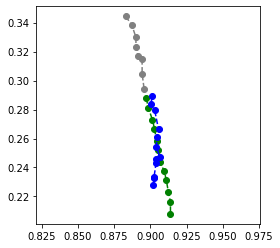

(0.008931388192477156, 0.023076546205159906)


In [ ]:
n=20
print_trayectoria(X,y,results,n)
print(average_displacement_error(results[n],y[n]))

Ejemplo de trayectoria real vrs predicción con datos denormalizados y error de la muestra:

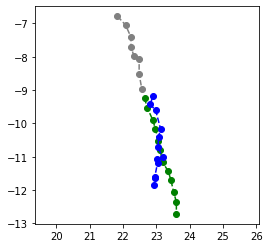

(24.653163443164846, 25.105037409105105)


In [ ]:
n=20
print_trayectoria(X_denormalized,Y_denormalized,results_denormalized,n)
print(average_displacement_error(results_denormalized[n],y[n]))

**Error ADE, FDE del training data:**

In [ ]:
#calculo de error de las trayectorias ADE, FDE con datos denormalizados
ADE_Training, FDE_Training = calculate_error_batch(results_denormalized,Y_denormalized)
print("ADE:",ADE_Training, "FDE:",FDE_Training)


ADE: 0.7339044026554032 FDE: 1.3329308222274505


#####Evaluación del modelo MLP con datos de prueba

Extacción y carga de Test Data

Test Data contiene 423 trayectorias de peatones


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/test/bookstore_3.txt',sep=' ', header=None, names=['time','id','x','y'])

df_test.describe(include="all")

,time,id,x,y
count,8460.000000,8460.000000,8460.000000,8460.000000
mean,7846.879433,211.000000,-2.098361,-1.368573
std,4228.993127,122.116458,14.998730,12.236613
min,0.000000,0.000000,-27.486000,-20.879000
25%,3912.000000,105.000000,-19.021000,-13.469000
50%,7716.000000,211.000000,0.059000,-4.437500
75%,11640.000000,317.000000,10.752000,10.400000
max,14484.000000,422.000000,23.401000,20.664000


Normalización de datos de prueba:

In [ ]:
#Normalizar datos de test
id_column_test = df_test.id
df_test.drop(columns=['time','id'], axis=1, inplace=True) #se quita la feature time del dataset
df_test = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)

df_test['id'] = id_column_test


In [ ]:
#división de features x, y para utilizarlos en el modelo de entrada multiple
X_test, y_test = sequences_to_supervised(df_test, n_steps_in, n_steps_out, n_features)

Redimension de datos de prueba para poder procesarlos con MLP

In [ ]:
# flatten input
n_input = X_test.shape[1] * X_test.shape[2] #dimension input 
X_test_flatten = X_test.reshape((X_test.shape[0], n_input)) #423,16

# flatten conditional y
n_input = y_test.shape[1] * y_test.shape[2] #dimension output
y_test_flatten = y_test.reshape((y_test.shape[0],n_input)) #423,24

#####Metricas del modelo con datos de prueba

In [ ]:
score = model.evaluate(X_test_flatten, y_test_flatten, verbose=1, batch_size=8)

print("\n")
print(model.metrics_names)
print(score)

53/53 [==============================] - 0s 1ms/step - loss: 2.9057e-04


['loss']
0.0002905670553445816


In [ ]:
#prediccion
results_test = model.predict(X_test_flatten)

In [ ]:
results_test = results_test.reshape(results_test.shape[0], 12, 2)


Denormalización de datos:

In [ ]:
#redimensionamiento para tener un array en 2D y poder denormalizar X
X_test_denormalized = np.array(X_test)
X_test_denormalized = X_test_denormalized.reshape(X_test_denormalized.shape[0]*X_test_denormalized.shape[1],X_denormalized.shape[2])
X_test_denormalized =  scaler.inverse_transform(X_test_denormalized)
X_test_denormalized = X_test_denormalized.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Y
Y_test_denormalized = np.array(y_test)
Y_test_denormalized = Y_test_denormalized.reshape(Y_test_denormalized.shape[0]*Y_test_denormalized.shape[1],Y_test_denormalized.shape[2])
Y_test_denormalized =  scaler.inverse_transform(Y_test_denormalized)
Y_test_denormalized = Y_test_denormalized.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Results
results_test_denormalized = np.array(results_test)
results_test_denormalized = results_test_denormalized.reshape(results_test_denormalized.shape[0]*results_test_denormalized.shape[1],results_test_denormalized.shape[2])
results_test_denormalized =  scaler.inverse_transform(results_test_denormalized)
results_test_denormalized = results_test_denormalized.reshape(results_test.shape[0],results_test.shape[1],results_test.shape[2])



**Error ADE, FDE del test data:**

In [ ]:
#calculo de error de las trayectorias ADE, FDE con datos denormalizados
ADE_Test, FDE_Test = calculate_error_batch(results_test_denormalized,Y_test_denormalized)
print("ADE:",ADE_Test, "FDE:",FDE_Test)

ADE: 0.7244169750284557 FDE: 1.342206718792062


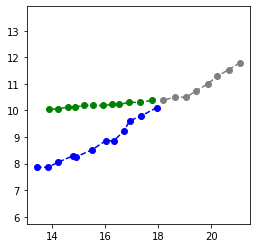

(17.59893597483062, 15.205897609441113)


In [ ]:
n=90
print_trayectoria(X_test_denormalized,Y_test_denormalized,results_test_denormalized,n)
print(average_displacement_error(results_test_denormalized[n],y[n]))